In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load data from the CSV file
data = pd.read_csv('data.csv')

# Check for missing values and handle them
data = data.dropna()  # Or handle them with interpolation, mean, or other methods

# Extract relevant columns
rouge_scores = data['Rouge_Scores'].values
length_of_summary = data['Length_of_Summary'].values
training_time = data['Training_Time'].values

# Normalize using MinMaxScaler
scaler = MinMaxScaler()

# Reshape data for scaling
normalized_rouge_scores = scaler.fit_transform(rouge_scores.reshape(-1, 1)).flatten()
normalized_length_of_summary = scaler.fit_transform(length_of_summary.reshape(-1, 1)).flatten()
normalized_training_time = scaler.fit_transform(training_time.reshape(-1, 1)).flatten()

# Weights for each parameter (adjustable based on your requirements)
weights = np.array([0.4, 0.3, 0.3])

# Create the normalized decision matrix with inverted values for Length_of_Summary and Training_Time
normalized_matrix = np.column_stack([
    normalized_rouge_scores,  # Higher values are better
    1 - normalized_length_of_summary,  # Lower length is better
    1 - normalized_training_time   # Shorter training time is better
])

# Apply weights to the normalized matrix
weighted_normalized_matrix = normalized_matrix * weights

# Ideal and Negative Ideal solutions
ideal_solution = np.max(weighted_normalized_matrix, axis=0)
negative_ideal_solution = np.min(weighted_normalized_matrix, axis=0)

# Calculate the separation measures
distance_to_ideal = np.sqrt(np.sum((weighted_normalized_matrix - ideal_solution)**2, axis=1))
distance_to_negative_ideal = np.sqrt(np.sum((weighted_normalized_matrix - negative_ideal_solution)**2, axis=1))

# Calculate the TOPSIS scores
topsis_scores = distance_to_negative_ideal / (distance_to_ideal + distance_to_negative_ideal)

# Rank the models based on TOPSIS scores
data['TOPSIS_Score'] = topsis_scores
data['Rank'] = data['TOPSIS_Score'].rank(ascending=False)

# Print the results
print("Model Ranking:")
print(data[['Model', 'TOPSIS_Score', 'Rank']].sort_values(by='Rank'))

# Save the results to a new CSV file
data.to_csv('result1.csv', index=False)


Model Ranking:
        Model  TOPSIS_Score  Rank
4        BART      0.625233   1.0
1       GPT-3      0.512862   2.0
2          T5      0.492997   3.0
0  BERTSumExt      0.487138   4.0
5     Pegasus      0.443025   5.0
3       XLNet      0.398509   6.0


Model Ranking Table:
        Model  Rouge_Scores  Length_of_Summary  Training_Time  Rank
4        BART          0.80                145              8   1.0
1       GPT-3          0.82                150             12   2.0
2          T5          0.78                140             10   3.0
0  BERTSumExt          0.75                130              9   4.0
5     Pegasus          0.79                138             13   5.0
3       XLNet          0.76                135             11   6.0


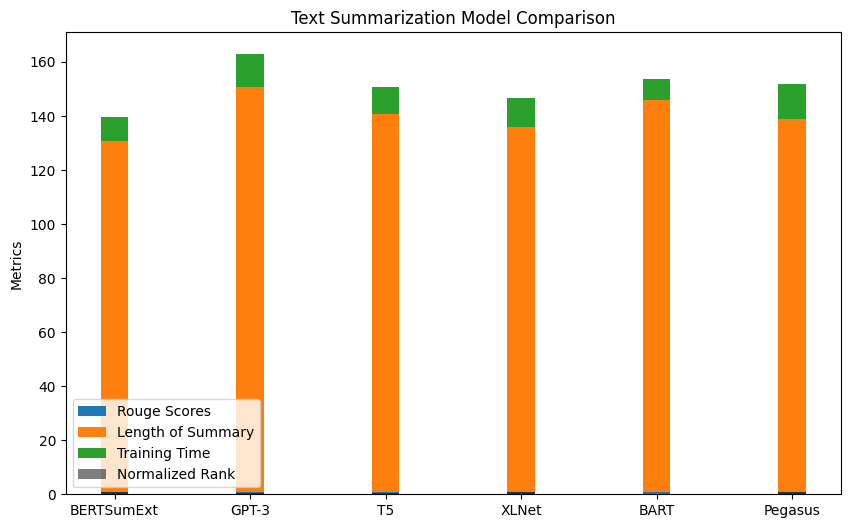

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import result
data=pd.read_csv('result1.csv')


# Display the table
print("Model Ranking Table:")
print(data[['Model', 'Rouge_Scores', 'Length_of_Summary', 'Training_Time', 'Rank']].sort_values(by='Rank'))

# Bar chart
labels = data['Model']
num_models = len(labels)

# Parameters for bar chart
rouge_scores = data['Rouge_Scores']
length_of_summary = data['Length_of_Summary']
training_time = data['Training_Time']
ranks = data['Rank']

# Normalize ranks to a scale of 0 to 1 for better comparison
normalized_ranks = ranks / np.max(ranks)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = range(num_models)

ax.bar(index, rouge_scores, width=bar_width, label='Rouge Scores')
ax.bar(index, length_of_summary, width=bar_width, label='Length of Summary', bottom=rouge_scores)
ax.bar(index, training_time, width=bar_width, label='Training Time', bottom=rouge_scores + length_of_summary)
ax.bar(index, normalized_ranks, width=bar_width, label='Normalized Rank', color='black', alpha=0.5)

ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.set_ylabel('Metrics')
ax.set_title('Text Summarization Model Comparison')

ax.legend()
plt.savefig('barchart.png')
plt.show()